<a href="https://colab.research.google.com/github/maicth/Seam-Carving---IMP301/blob/main/Design_filters_for_image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

# **Q1: Butterworth notch reject filter**

In [ ]:
def FT(image):
    return np.fft.fft2(image)

def IFT(G):
    return np.fft.ifft2(G)

In [ ]:
def Calculate_D(M, N, uk, vk):
    Dk = np.zeros([M, N])
    D_k = np.zeros([M, N])

    for i in range (0, M):
        for j in range (0, N):
            Dk[i, j] = np.sqrt((i - M/2 - uk) ** 2 + (j - N/2 - vk) ** 2)
            D_k[i, j] = np.sqrt((i - M/2 + uk) ** 2 + (j - N/2 + vk) ** 2)
    return Dk, D_k

In [ ]:
def BNRF(D0, M, N, u, v, k, n=1):
    H = np.ones([M, N])

    for i in range(0, k):
        D = Calculate_D(M, N, u[i], v[i])
        H *= np.multiply(
            1 / (1 + (D0 / D[0]) ** n),
            1 / (1 + (D0 / D[1]) ** n)
        )

    return H

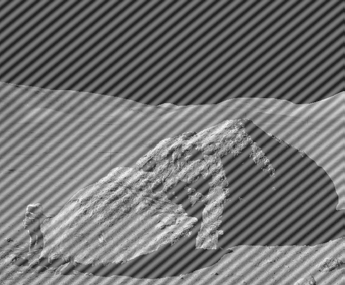

In [ ]:
img1 = cv2.imread('/content/1.png', 0)
cv2_imshow(img1)

In [ ]:
F = FT(img1)
F_shift = np.fft.fftshift(F)

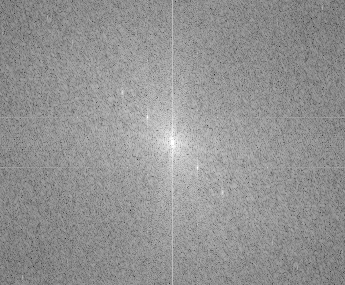

In [ ]:
spectrum_1 = 20 * np.log(np.abs(F_shift))
cv2_imshow(spectrum_1)

In [ ]:
M, N = img1.shape
k = 2
u = [52, 25]
v = [52, 25]
D0 = 10

In [ ]:
H = BNRF(D0, M, N, u, v, k, 10)

In [ ]:
G = np.multiply(H, F_shift)

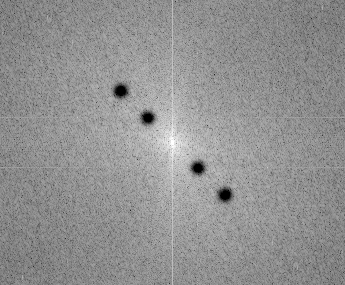

In [ ]:
spectrum = 20 * np.log(np.abs(G))
cv2_imshow(spectrum)

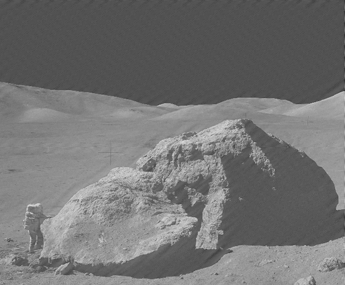

In [ ]:
G_shift = np.fft.ifftshift(G)
g = np.fft.ifft2(G_shift)

img_back = np.real(g)

cv2_imshow(img_back)

# **Q2: Mean filter**

In [ ]:
def new_padding_zero_img(img, kernel_size):
  h, w = img.shape
  new_img = np.zeros((h + kernel_size[0] - 1, w + kernel_size[1] - 1))
  new_h, new_w = new_img.shape
  padding_h = kernel_size[0] // 2
  padding_w = kernel_size[1] // 2
  new_img[padding_h: h + padding_h, padding_w: w + padding_w] = img
  return new_img

In [ ]:
def mean_filter(temp, kernel_size, type, Q=1):
    h, w = kernel_size
    if type == 'arith':
        mean = np.sum(temp) / (h * w)
    elif type == 'geo':
        mean = np.prod(temp) ** (1/ (h * w))
    elif type == 'harmonic':
        mean = (h * w) / (np.sum(1/temp))
    elif type == 'contraharmonic':
        mean = np.sum(temp ** (Q+1)) / np.sum(temp ** Q)
    return mean

In [ ]:
def mean_filter_img(img, kernel_size, type, Q=1):
  h, w  = img.shape
  size_h = kernel_size[0] // 2  # padding size for each of 4 corner column, row
  size_w = kernel_size[1] // 2

  padding_img = new_padding_zero_img(img, kernel_size)


  filtered_img = padding_img.copy()

  # replace each pixel by median of temp kernel
  for i in range(size_h, h + size_h):
    for j in range(size_w, w + size_w):
      temp = padding_img [i-size_h: i+size_h+1, j-size_w:j+size_w+1]
      mean = mean_filter(temp, kernel_size, type, Q)
      filtered_img[i, j] = mean

  return (filtered_img[size_h: h + size_h, size_w: w + size_w]).astype(int)

In [ ]:
def calculate_histogram(img):
  h, w = img.shape
  L = 256
  counter = np.array([0 for _ in range(0, L)])
  for i in range (0, h):
    for j in range(0, w):
      counter[img[i, j]] += 1
  return counter

In [ ]:
img2 = cv2.imread('/content/2.png', 0)

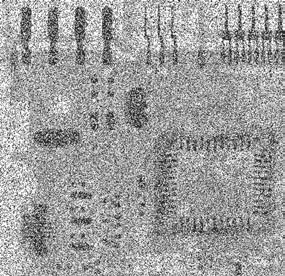

In [ ]:
cv2_imshow(img2)

In [ ]:
img2.shape

(276, 285)

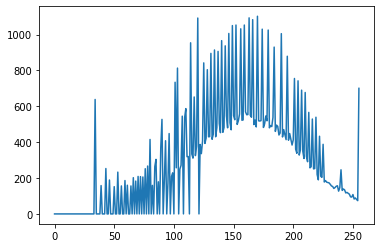

In [ ]:
plt.plot(calculate_histogram(img2))

In [ ]:
kernel_size = (7, 7)

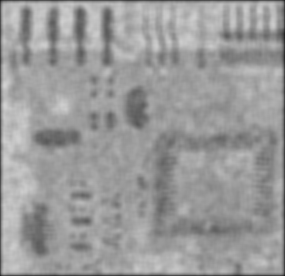

In [ ]:
img_2_arithmetic1 = mean_filter_img(img2, kernel_size, 'arith')
img_2_arithmetic2 = mean_filter_img(img_2_arithmetic1, (3, 3), 'arith')
cv2_imshow(img_2_arithmetic2)

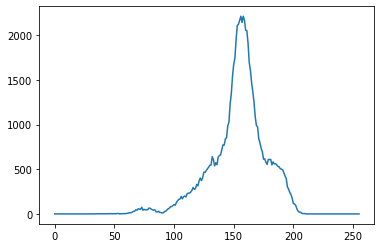

In [ ]:
plt.plot(calculate_histogram(img_2_arithmetic2))

In [ ]:
def order_statistic_filter(temp, kernel_size, type, d):
    h, w = kernel_size
    if type == 'median':
        f = np.median(temp)
    elif type == 'max':
        f = np.max(temp)
    elif type == 'min':
        f = np.min(temp)
    elif type == 'mid':
        f = (np.min(temp) + np.max(temp)) / 2
    elif type == 'alpha':
        temp = temp.flatten()
        temp.sort()
        f = np.sum(temp[int(d/2): h*w - 1 - int(d/2)]) / (h*w - d)
    return f


In [ ]:
def order_statistic_filter_img(img, kernel_size, type, d=2):
  h, w  = img.shape
  size_h = kernel_size[0] // 2  # padding size for each of 4 corner column, row
  size_w = kernel_size[1] // 2

  padding_img = new_padding_zero_img(img, kernel_size)


  filtered_img = padding_img.copy()

  # replace each pixel by median of temp kernel
  for i in range(size_h, h + size_h):
    for j in range(size_w, w + size_w):
      temp = padding_img [i-size_h: i+size_h+1, j-size_w:j+size_w+1]
      f = order_statistic_filter(temp, kernel_size, type, d)
      filtered_img[i, j] = f

  return (filtered_img[size_h: h + size_h, size_w: w + size_w]).astype(int)

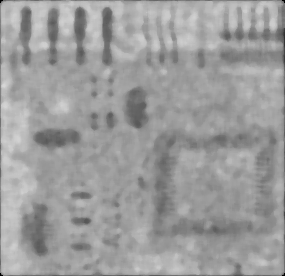

In [ ]:
img2_arith = mean_filter_img(img2, (3,3), 'arith')
img2_med = order_statistic_filter_img(img2_arith, (7,7), 'median', 4)

cv2_imshow(img2_med)

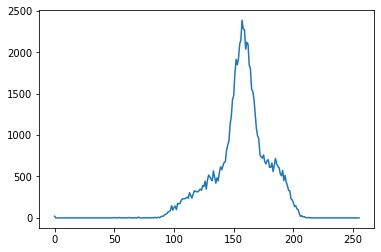

In [ ]:
plt.plot(calculate_histogram(img2_med))

# **Q3: Median filter**

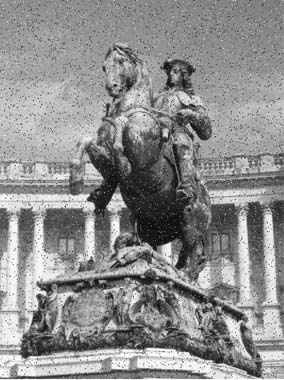

In [ ]:
img3 = cv2.imread('/content/3.png', 0)
cv2_imshow(img3)

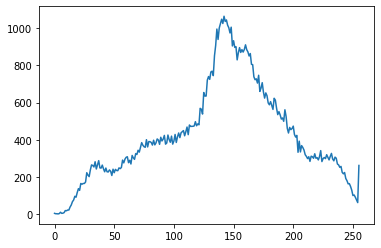

In [ ]:
plt.plot(calculate_histogram(img3))

In [ ]:
kernel_size = (5,5)

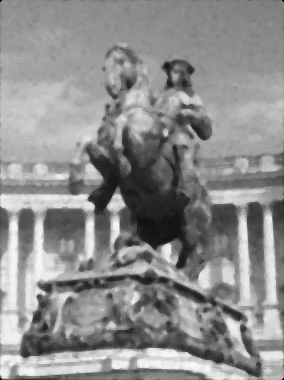

In [ ]:
img3_median = order_statistic_filter_img(img3, kernel_size, 'median')
cv2_imshow(img3_median)

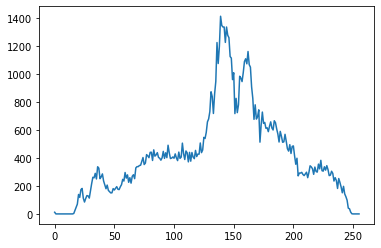

In [ ]:
plt.plot(calculate_histogram(img3_median))

# **Q4: Motion deblur using Wiener filter**

In [ ]:
def PSFMotion(size, d, thick):
  h = np.zeros((size[0],size[1]))
  h = cv2.line(h,(size[0] // 2 - d //2, size[1] // 2 - d //2), (size[0] // 2 + d//2, size[1] // 2 + d//2), 255, thick )
  return h


In [ ]:
def wiener_filter(img, kernel, K):
  kernel /= np.sum(kernel)
  print(kernel.shape)
  f = np.copy(img)
  f = np.fft.fft2(f)
  f = np.fft.fftshift(f)
  kernel = np.fft.fft2(kernel, s = img.shape)
  kernel = np.fft.fftshift(kernel)

  kernel = (kernel) / (np.abs(kernel) ** 2 + K)

  f = f * kernel
  f = np.fft.ifftshift(f)
  f = np.abs(np.fft.ifft2(f))
  return f

In [ ]:
img4 = cv2.imread('/content/4.png', 0)

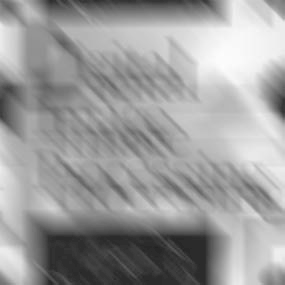

In [ ]:
cv2_imshow(img4)

In [ ]:
M, N = img4.shape

In [ ]:
F = np.fft.fft2(img4)
F_shift = np.fft.fftshift(F)

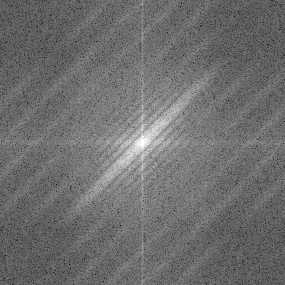

In [ ]:
spectrum = 20 * np.log(np.abs(F_shift))

cv2_imshow(spectrum)

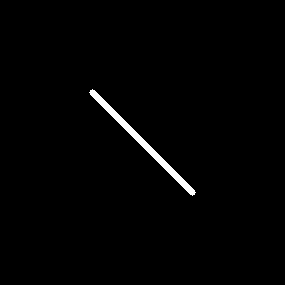

In [ ]:
cv2_imshow(h)

In [ ]:
kernel_size = (30, 30)
length = 40
thickness = 2
K = 0.001

img_back = wiener_filter(img4, PSFMotion(kernel_size, length, thickness), K )

(30, 30)


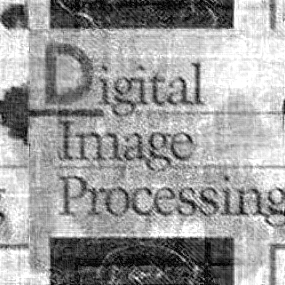

In [ ]:
cv2_imshow(img_back)

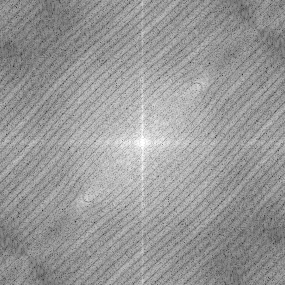

In [ ]:
f = np.fft.fft2(img_back)
f_shift = np.fft.fftshift(f)

spectrum = 20 * np.log(np.abs(f_shift))

cv2_imshow(spectrum)

# **Q5: Deblur by Wiener filter**

In [ ]:
def Calculate_D(M, N):
    D = np.zeros([M, N])

    for i in range (0, M):
        for j in range (0, N):
            D[i, j] = np.sqrt((i) ** 2 + (j) ** 2)
    return D

In [ ]:
def LPF(D0, M, N):
    H = np.zeros([M, N])
    D = Calculate_D(M, N)
    for i in range(0, M):
        for j in range (0, N):
            if D[i, j] <= D0:
                H[i, j] = 1
            else:
                H[i, j] = 0
    return H

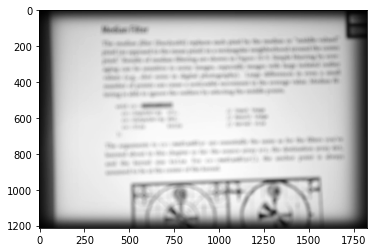

In [ ]:
img5 = cv2.imread('/content/5.jpg', 0)

plt.imshow(img5, cmap='gray')
# plt.imshow(img5)

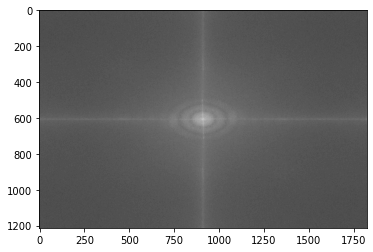

In [ ]:
f = np.fft.fft2(img5)
f_shift = np.fft.fftshift(f)

spectrum = 20 * np.log(np.abs(f_shift))

plt.imshow(spectrum, cmap='gray')

In [ ]:
M, N = img5.shape

In [ ]:
h = LPF(30, M, N)
h /= np.sum(h)
H = np.fft.fft2(h)

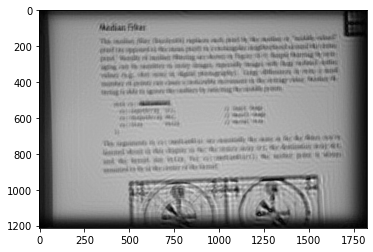

In [ ]:
H_shift = np.conj(H) / (np.abs(H)**2 + 0.005)
G = np.multiply(H_shift, f)

g_shift = np.fft.ifftshift(G)
spec = 20 * np.log(np.abs(g_shift))
plt.imshow(spec, cmap='gray')
g = np.abs(np.fft.ifft2(G))
plt.imshow(g, cmap='gray')

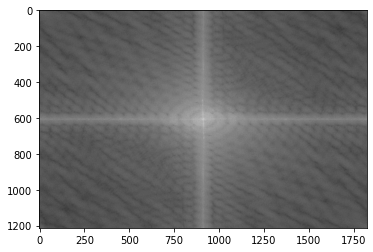

In [ ]:
g_shift = np.fft.fft2(g)

g_shift = np.fft.ifftshift(g_shift)
spec = 20 * np.log(np.abs(g_shift))

plt.imshow(spec, cmap='gray')

## **Cách 2**

In [ ]:
M, N = img5.shape
img5.shape

(1212, 1823)

In [ ]:
h = np.zeros([M, N])

In [ ]:
def PSF(size,R):
  h = np.zeros((size[0],size[1]))
  point = (size[0] //2 , size[1] // 2)
  h = cv2.circle(h, point, R, 255, -1, 8)
  return h


In [ ]:
def wiener_filter(img, kernel, K):
  kernel /= np.sum(kernel)
  print(kernel.shape)
  f = np.copy(img)
  f = np.fft.fft2(f)
  f = np.fft.fftshift(f)
  kernel = np.fft.fft2(kernel, s = img.shape)
  kernel = np.fft.fftshift(kernel)

  kernel = (kernel) / (np.abs(kernel) ** 2 + K)

  f = f * kernel
  f = np.fft.ifftshift(f)
  f = np.abs(np.fft.ifft2(f))
  return f

In [ ]:
new_img = wiener_filter(img5, PSF((27, 27), 53), 1/400)

(27, 27)


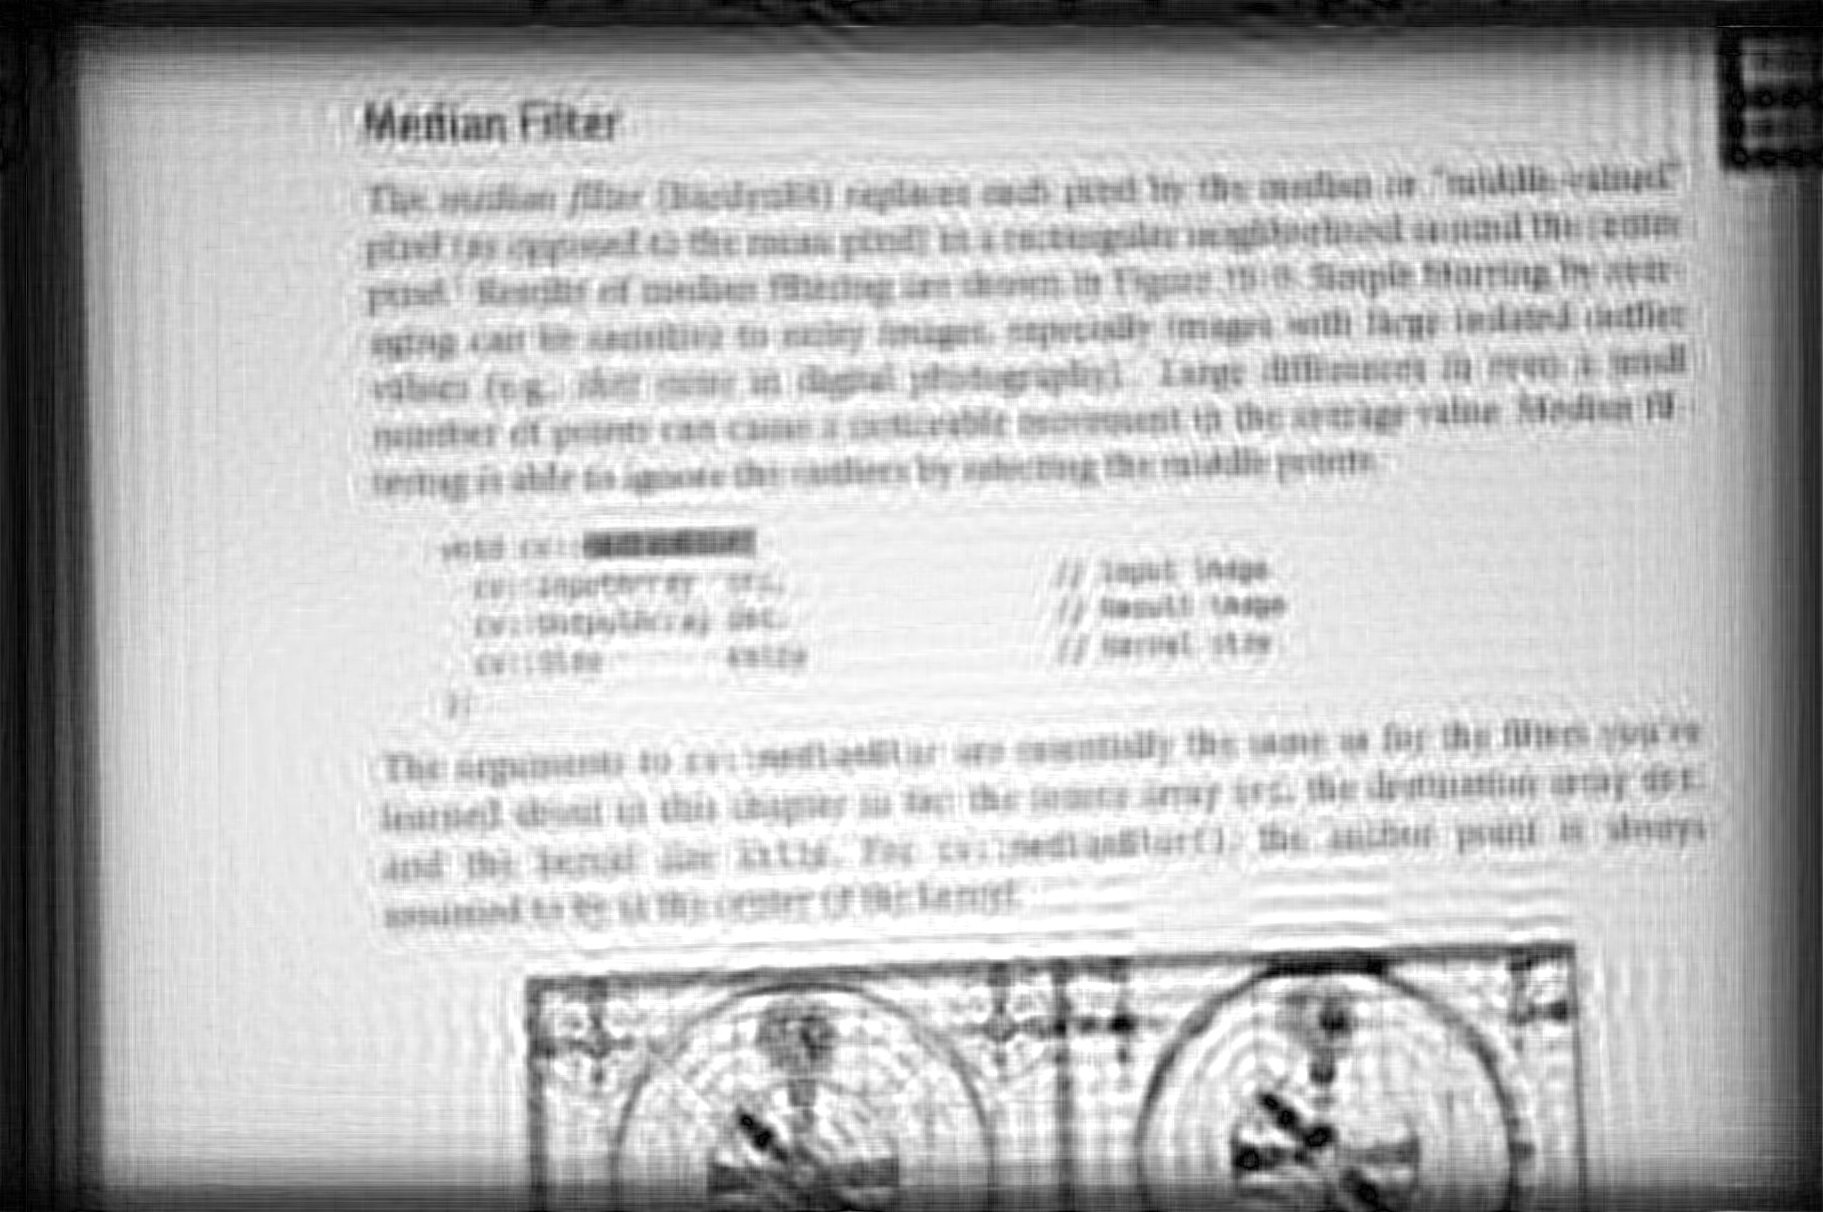

In [ ]:
# plt.imshow(new_img, cmap='gray')
cv2_imshow(new_img)